In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from seaborn import pairplot
from ISLP import load_data
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from statsmodels.api import OLS
from statsmodels.nonparametric.smoothers_lowess import lowess
from pygam import LinearGAM, s

# Prevent warnings 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### Q6
In this exercise, you will further analyze the Wage data set considered throughout this chapter.

In [2]:
Wage = load_data('Wage')
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


(a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. Make a plot of the resulting polynomial fit to the data.

The lowest MSE is 39.924123729575115 and is achieved with a 4 degree polynomial


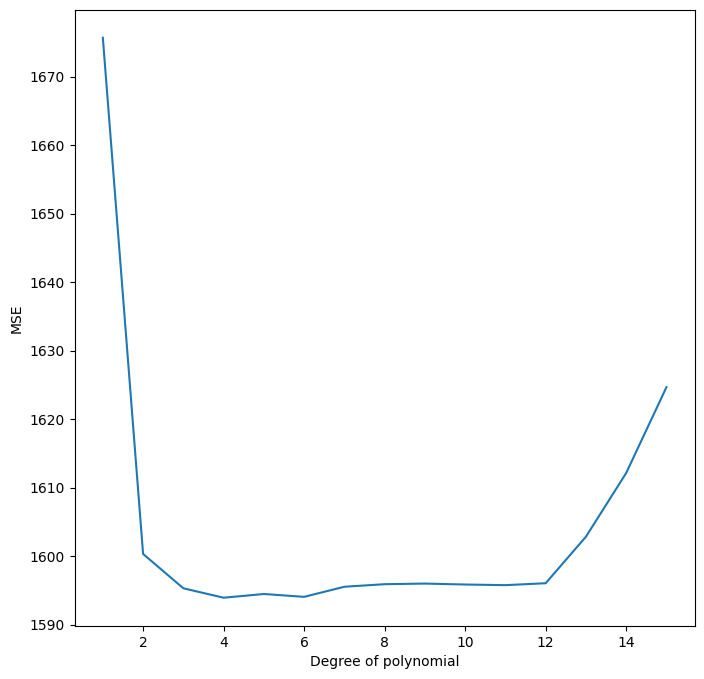

In [3]:
# Define predictor and response 
X = pd.DataFrame(Wage['age'])
y = pd.DataFrame(Wage['wage'])

# Define a function to find the best polynomial using k-folds cross-validation 
def tune_poly(degrees, X, y, K):
    results = pd.DataFrame(columns=['Degree', 'MSE'])
    for degree_i in degrees:
        # Make order m variables 
        poly_features = PolynomialFeatures(degree=degree_i, include_bias=False)
        X_poly = poly_features.fit_transform(X)
        # Define linear regression model and calculate cross-validation scores
        model = LinearRegression()
        scores = cross_val_score(model, X_poly, y, cv=K, scoring='neg_mean_squared_error')
        mse = -np.mean(scores)  # Make errors positive
        # Append the values to results 
        new_row = pd.DataFrame({'Degree': [degree_i], 'MSE': [mse]})
        results = pd.concat([results, new_row], ignore_index=True)
    return results
    
# Define the range of degrees to test 
degrees_p = [x for x in range(1,16)]

# Fit polynomial regression for all the degree and find test MSE
results_p = tune_poly(degrees_p, X, y, 10)

# Find the degree with the lowest MSE --> optimal polynomial degree 
min_mse_index_p = results_p['MSE'].idxmin()
min_mse_row_p= results_p.loc[min_mse_index_p]
mse_min_p, best_degree = min_mse_row_p['MSE'], min_mse_row_p['Degree']
print("The lowest MSE is {0} and is achieved with a {1} degree polynomial".format(np.sqrt(mse_min_p), best_degree))

# Plot the variation in MSE as a function of degree
plt.figure(figsize=(8, 8))
plt.plot(results_p['Degree'], results_p['MSE'])
plt.xlabel('Degree of polynomial')
plt.ylabel('MSE')
plt.show()

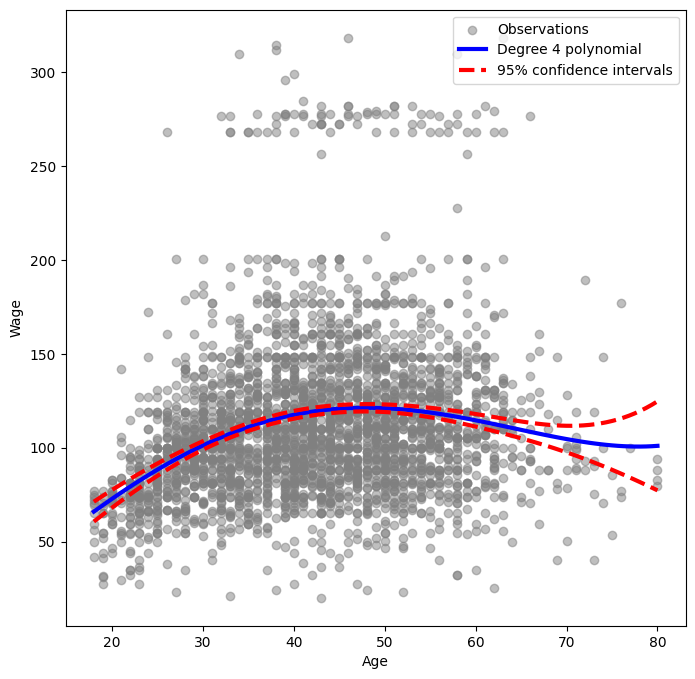

In [4]:
# Make a set of equally spaced age values to make prediction line smooth 
age_values = pd.DataFrame({'age': np.linspace(Wage['age'].min(), Wage['age'].max(), 100)})
poly_features = PolynomialFeatures(degree=4, include_bias=False)

# Make 2 sets of features ; one to fit the model and the other to make a smooth plot 
X_poly = poly_features.fit_transform(X)
X_smooth = poly_features.transform(age_values)
M = OLS(y, X_poly).fit() # Use OLS from statsmodel to get confidence intervals 
    
# Make predictions on smooth data and find 95% confidence intervals
preds_p = M.get_prediction(X_smooth)
bands_p = preds_p.conf_int(alpha=0.05) 

# Set up plot and plot observations 
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(Wage['age'], Wage['wage'], facecolor='gray', alpha=0.5, label='Observations')
    
# Plot the predicted mean and confidence intervals
ax.plot(age_values['age'], preds_p.predicted_mean, 'b', linewidth=3, label='Degree 4 polynomial')  
ax.plot(age_values['age'], bands_p[:, 0], 'r--', linewidth=3, label='95% confidence intervals') 
ax.plot(age_values['age'], bands_p[:, 1], 'r--', linewidth=3)
    
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.legend()
plt.show()

(b) Fit a step function to predict wage using age, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

The lowest MSE is 39.94623016749171 and is achieved with 16 cuts


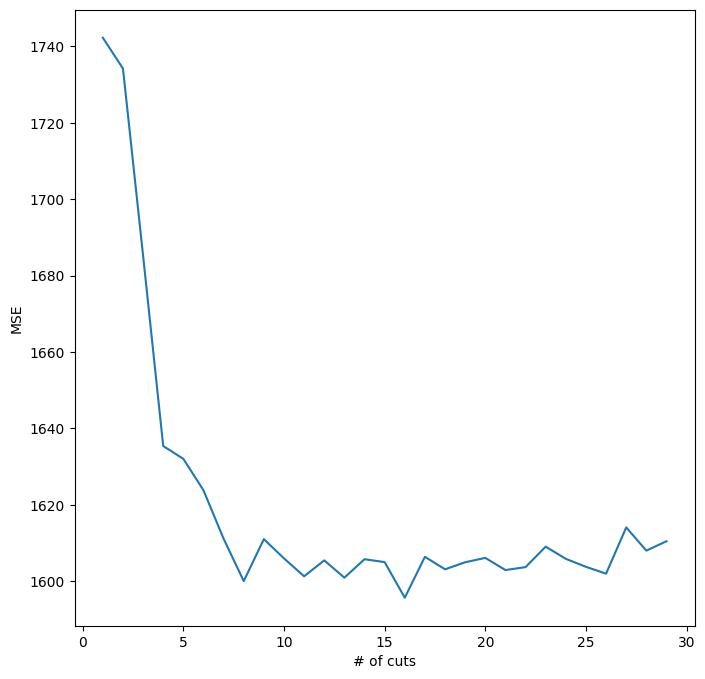

In [5]:
# Define a function to find the best number of cuts using k-folds cross validation
def tune_step(splits, X, y, K):
    results = pd.DataFrame(columns=['# of cuts', 'MSE'])
    for split in splits:
        # Make m splits of the data and fit linear regression models  
        cut_age = pd.get_dummies(pd.cut(Wage['age'],split))
        model = LinearRegression()
        scores = cross_val_score(model, cut_age, y, cv=K, scoring='neg_mean_squared_error')
        mse = -np.mean(scores)  # Make errors positive
        # Append the values to results 
        new_row = pd.DataFrame({'# of cuts': [split], 'MSE': [mse]})
        results = pd.concat([results, new_row], ignore_index=True)
    return results
    
# Define the range of cuts to test 
splits = [x for x in range(1,30)]
results_sw = tune_step(splits, X, y, 10)

# Find the cut with the lowest MSE --> optimal # of cuts
min_mse_index_sw = results_sw['MSE'].idxmin()
min_mse_row_sw= results_sw.loc[min_mse_index_sw]
mse_min_sw, best_cut = min_mse_row_sw['MSE'], min_mse_row_sw['# of cuts']
print("The lowest MSE is {0} and is achieved with {1} cuts".format(np.sqrt(mse_min_sw), best_cut))

# Plot the variation in MSE as a function of # of cuts 
plt.figure(figsize=(8, 8))
plt.plot(results_sw['# of cuts'], results_sw['MSE'])
plt.xlabel('# of cuts')
plt.ylabel('MSE')
plt.show()

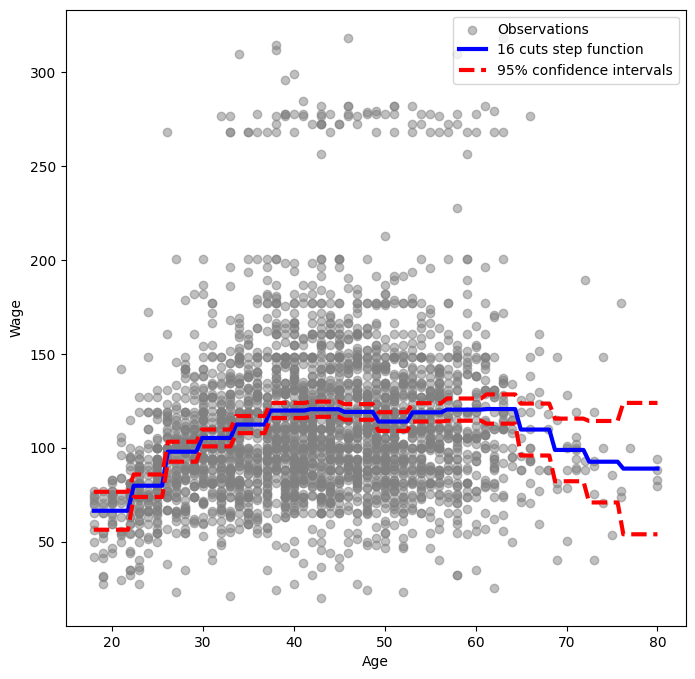

In [6]:
# Make 2 sets of features ; one to fit the model and the other to make a smooth plot
X_cut = pd.get_dummies(pd.cut(X['age'],16))
X_cut_smooth = pd.get_dummies(pd.cut(age_values['age'],16))
model = OLS(y, X_cut).fit()

# Make predictions on smooth data and find 95% confidence intervals
preds_pw = model.get_prediction(X_cut_smooth)
bands_pw = preds_pw.conf_int(alpha=0.05) 

# Set up plot and plot observations 
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(Wage['age'], Wage['wage'], facecolor='gray', alpha=0.5, label='Observations')
    
# Plot the predicted mean and confidence intervals
ax.plot(age_values['age'], preds_pw.predicted_mean, 'b', linewidth=3, label='16 cuts step function')  
ax.plot(age_values['age'], bands_pw[:, 0], 'r--', linewidth=3, label='95% confidence intervals') 
ax.plot(age_values['age'], bands_pw[:, 1], 'r--', linewidth=3)
    
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
ax.legend()
plt.show()

#### Q8
Fit some of the non-linear models investigated in this chapter to the Auto data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer

In [7]:
Auto = load_data('Auto')
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


> To find which variables we should use to predict horsepower, we need to plot pairwise scatter plots and pick the most suitable one. 

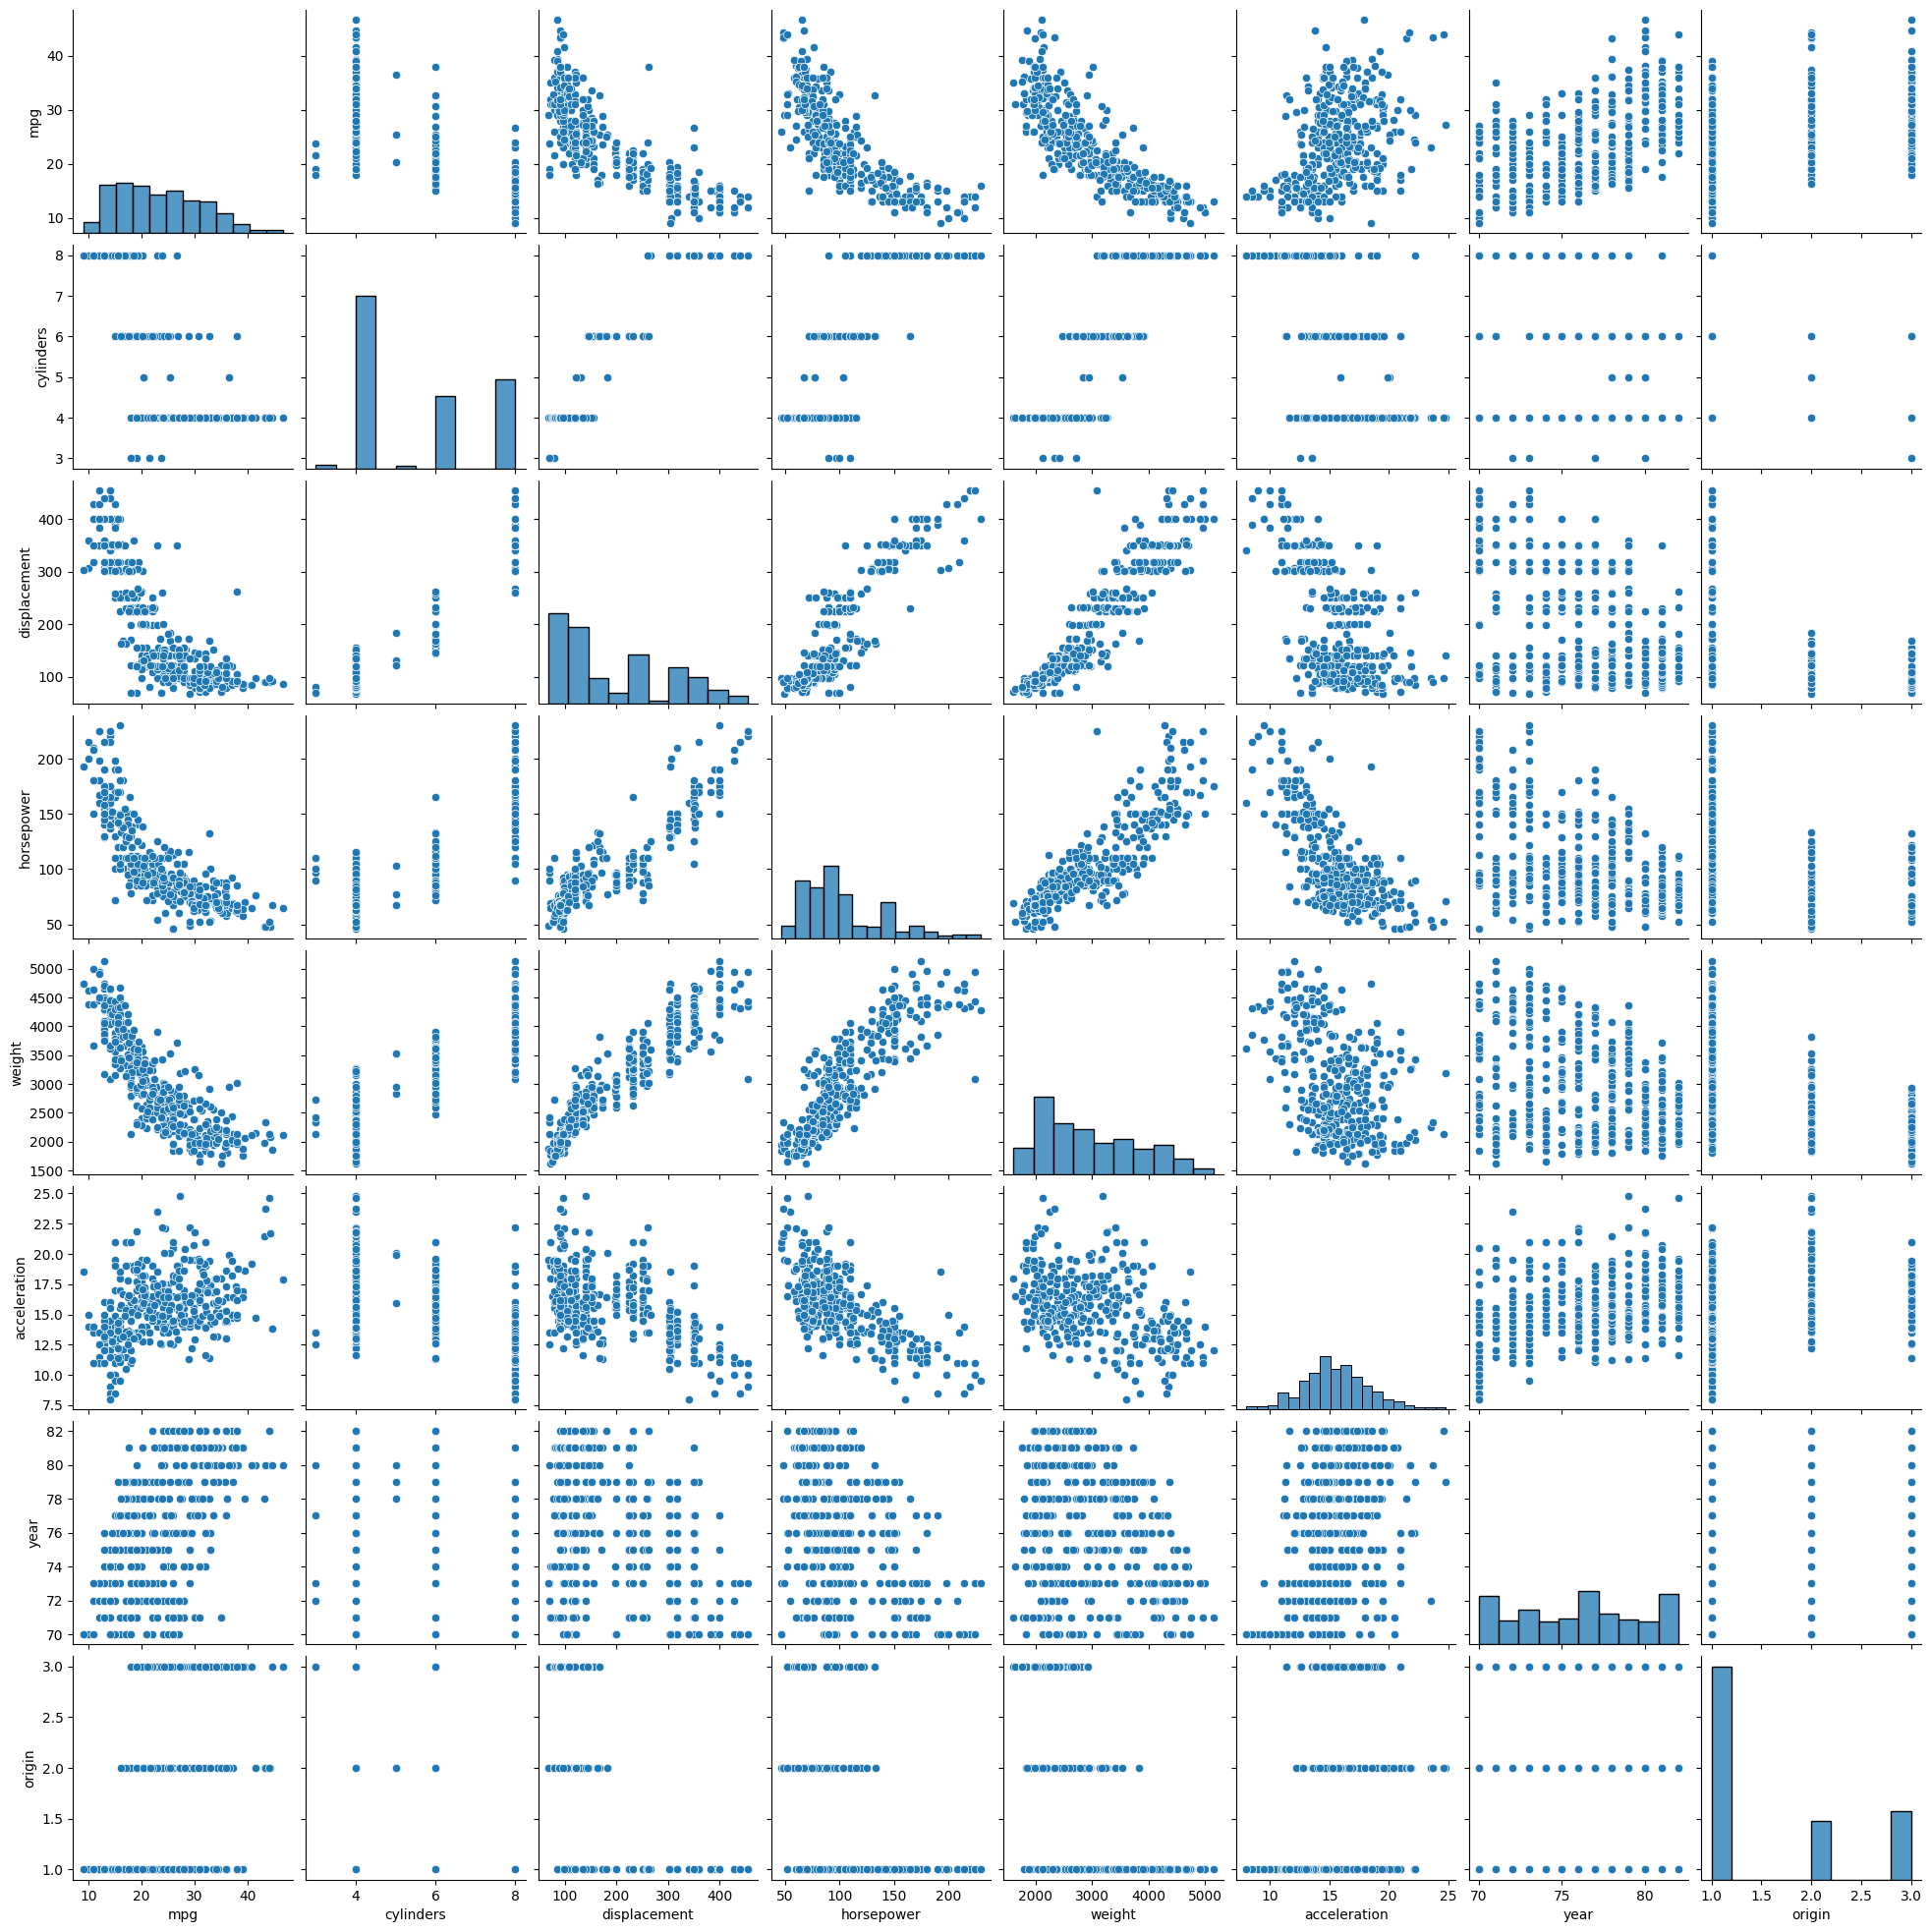

In [8]:
pairplot(Auto);

> Horsepower & [mpg, acceleration]  exhibit non-linear relationship. I will be using mpg as a predictor for this analysis. 

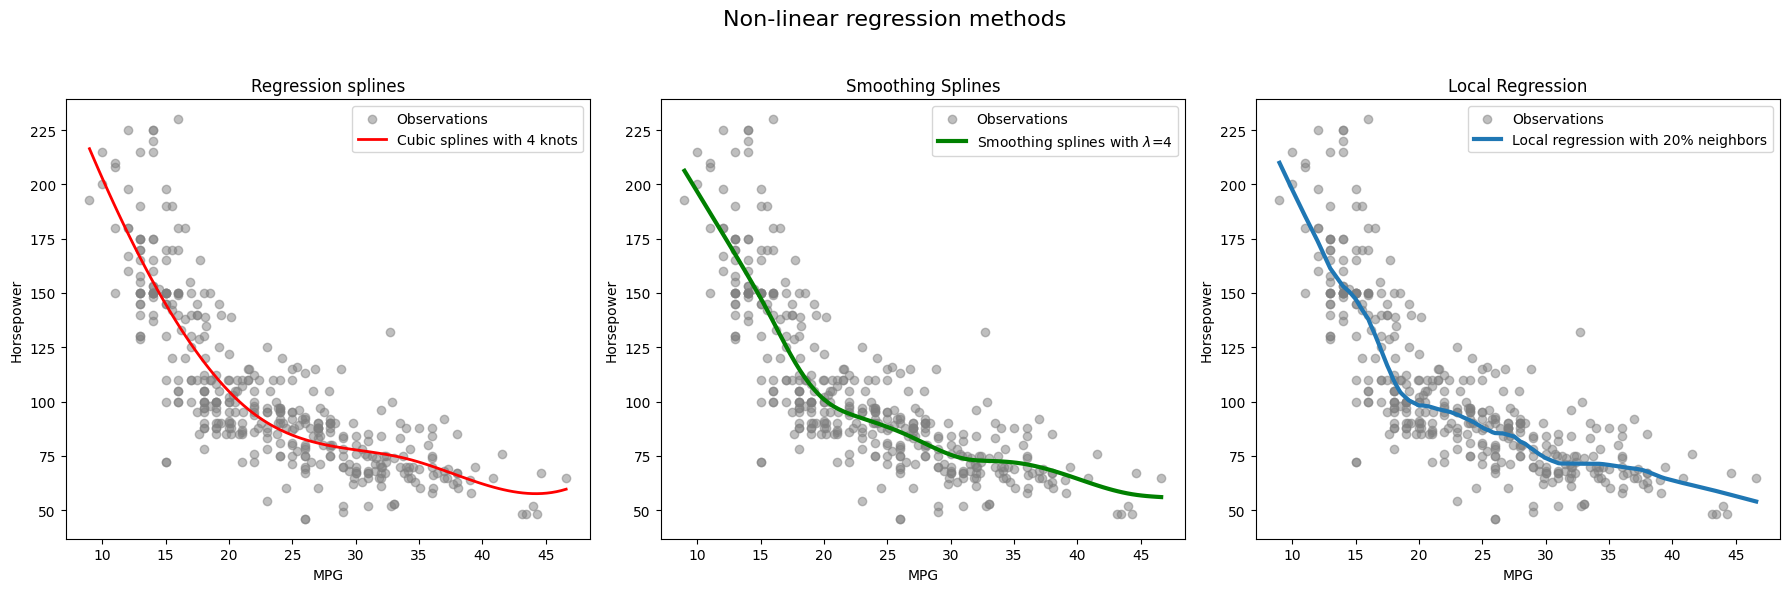

In [9]:
X_auto = pd.DataFrame(Auto['mpg'])
y_auto = pd.DataFrame(Auto['horsepower']) 
mpg_grid = np.linspace(X_auto.min(), X_auto.max(), 100) # Set of values for smooth plot 
mpg_grid_df = pd.DataFrame(mpg_grid, columns=['mpg']) # B-splines expects feature names 

# Set up subplots 
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Non-linear regression methods", fontsize=16)

# Regression splines 
splines = SplineTransformer(degree=3, n_knots=4) 
basis = splines.fit_transform(X_auto)  
basis_grid = splines.transform(mpg_grid_df) 

rs_model = OLS(y_auto, basis).fit()  # Fit the OLS model on basis for real data 
y_pred_bspline_grid = rs_model.predict(basis_grid)  # Make predictions on smooth data

axs[0].scatter(X_auto, y_auto, facecolor='gray', alpha=0.5, label='Observations')
axs[0].plot(mpg_grid, y_pred_bspline_grid, 'r-', linewidth=2, label='Cubic splines with 4 knots')
axs[0].set_title('Regression splines')
axs[0].set_xlabel('MPG')
axs[0].set_ylabel('Horsepower')
axs[0].legend()

# Smoothing Splines
gam = LinearGAM(s(0), lam=4).fit(X_auto, y_auto)  
y_pred_gam = gam.predict(mpg_grid)

axs[1].scatter(X_auto, y_auto, facecolor='gray', alpha=0.5, label='Observations')
axs[1].plot(mpg_grid, y_pred_gam, 'g-', linewidth=3, label=r'Smoothing splines with $\lambda$=4')
axs[1].set_title('Smoothing Splines')
axs[1].set_xlabel('MPG')
axs[1].set_ylabel('Horsepower')
axs[1].legend()

# Local Regression 
fitted = lowess(y_auto['horsepower'], X_auto['mpg'], frac=0.2, return_sorted=True)
x_vals, y_vals = fitted[:, 0], fitted[:, 1]

axs[2].scatter(X_auto, y_auto, facecolor='gray', alpha=0.5, label='Observations')
axs[2].plot(x_vals, y_vals, label='Local regression with 20% neighbors', linewidth=3)
axs[2].set_title('Local Regression')
axs[2].set_xlabel('MPG')
axs[2].set_ylabel('Horsepower')
axs[2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()